In [1]:
import pandas as pd
import plotly.express as px
import wandb
import plotly.graph_objects as go

In [2]:
def export_project(project_name: str):
    """Load all runs from wandb project"""
    api = wandb.Api()
    entity, project = "smtb2023", project_name
    runs = api.runs(entity + "/" + project)

    summary_list, config_list, name_list = [], [], []
    for run in runs:
        summary_list.append(run.summary._json_dict)
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
        name_list.append(run.name)

    runs_df = pd.DataFrame({"summary": summary_list, "config": config_list, "name": name_list})
    rows = []
    for i, row in runs_df.iterrows():
        new_row = {}
        new_row.update(row.summary)
        new_row.update(row.config)
        new_row.update({"name": row.name})
        rows.append(new_row)
    return pd.DataFrame(rows)


In [3]:
df = export_project("fluorescence")
df["layer_prog"] = df.apply(lambda x: x["layer_num"] / int(x["model_name"].split("_")[1][1:]), axis=1)
df.sort_values("model_name", inplace=True)
df["total_layers"] = df["model_name"].apply(lambda x: int(x.split("_")[1][1:]))
df.sort_values("total_layers", inplace=True)

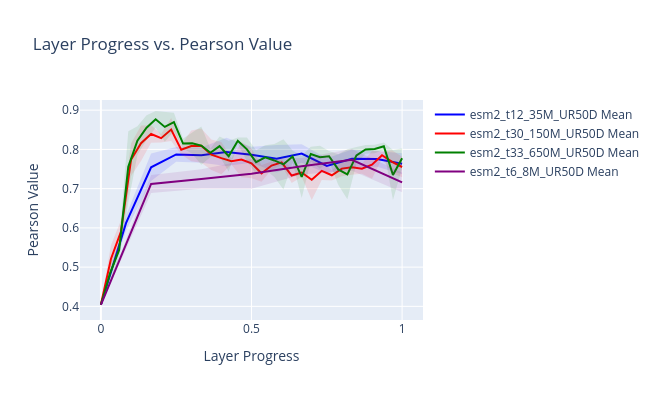

In [5]:
import plotly.graph_objects as go

# Colors for different models as RGB tuples
colors = [
    (0, 0, 255),  # blue
    (255, 0, 0),  # red
    (0, 128, 0),  # green
    (128, 0, 128),  # purple
    (255, 165, 0),  # orange
    (0, 255, 255),  # cyan
    # ... add more colors if needed
]

fig = go.Figure()

for i, (name, df_i) in enumerate(df.groupby("model_name")):
    color = colors[i % len(colors)]  # Cycle through colors if there are more models than colors

    grouped = df_i.groupby("layer_prog")["val/pearson"].agg(["mean", "std"]).fillna(0)

    # Line for mean value
    fig.add_trace(
        go.Scatter(
            x=grouped.index,
            y=grouped["mean"],
            mode="lines",
            line=dict(color=f"rgb{color}"),
            name=f"{name} Mean",
        )
    )

    # Filled area for standard deviation
    fig.add_trace(
        go.Scatter(
            x=grouped.index.tolist() + grouped.index.tolist()[::-1],
            y=(grouped["mean"] - grouped["std"]).tolist() + (grouped["mean"] + grouped["std"]).tolist()[::-1],
            fill="toself",
            fillcolor=f"rgba({color[0]},{color[1]},{color[2]},0.1)",
            line=dict(color="rgba(255,255,255,0)"),
            name=f"{name} Std Dev",
            showlegend=False,
        )
    )

fig.update_layout(
    title="Layer Progress vs. Pearson Value",
    xaxis_title="Layer Progress",
    yaxis_title="Pearson Value",
    showlegend=True,
    width=700,
    height=400,
)

fig.show()